In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [ ]:
scp = pd.read_csv("supernova data.txt", comment="#", sep="\t", names=["redshift", "m_distance", "m_distance_err"])
scp

,redshift,m_distance,m_distance_err
1993ag,0.050043,36.773002,0.153149
1993o,0.052926,36.824142,0.148454
1993h,0.025130,35.167818,0.165421
1993b,0.070086,37.567740,0.154031
1992bs,0.062668,37.551580,0.145317
...,...,...,...
p454,0.695000,42.920740,0.413583
p455,0.284000,40.784982,0.199874
p524,0.508000,42.137552,0.212952
p528,0.781000,43.382553,0.341140


# Code

### Decorators

In [ ]:
def vectorize(f):
    def func(*args):
        return np.vectorize(lambda z: f(z, *args[1:]))(args[0])
    return func


def plot(title, xlabel = None, ylable = None):
    def decorator(f):
        def plot_func(*args):
            plt.figure(figsize=(10, 7))
            f(*args)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylable)
            plt.legend()
            plt.show()
        return plot_func
    return decorator

### Model

In [ ]:
@vectorize
def distModulus(redshift, omega_m, omega_l):
    hubble_distance = 4380
    omega_k = 1 - omega_m - omega_l
    integrand = lambda z : 1 / np.sqrt(omega_m*(1+z)**3 + omega_k * (1+z)**2 + omega_l)
    integral = sp.integrate.quad(integrand, 0, redshift)[0]

    if omega_k > 0:
        proper_distance = hubble_distance * np.sinh(np.sqrt(omega_k) * integral) / np.sqrt(omega_k)
    elif omega_k < 0:
        proper_distance = hubble_distance * np.sin(np.sqrt(-omega_k) * integral) / np.sqrt(-omega_k)
    else:
        proper_distance = hubble_distance * integral

    return 5 * np.log10(proper_distance * (1 + redshift)) + 25

### Algorithm

In [ ]:
def derivative(f, x, dx):
    return (f(x + dx) - f(x)) / dx


def errFunction(data, omega_m, omega_l):
    return np.sum((data["m_distance"] - distModulus(data["redshift"], omega_m, omega_l))**2 / data["m_distance_err"]**2)


def grad_errFunction(data, omega_m, omega_l):
    d_Om = derivative(lambda Om: errFunction(data, Om, omega_l), omega_m, 1e-3)
    d_Ol = derivative(lambda Ol: errFunction(data, omega_m, Ol), omega_l, 1e-3)
    return d_Om, d_Ol


def posterior(data, omega_m, omega_l):
    err = errFunction(data, omega_m, omega_l)
    return np.exp(-err)


def propose(Om_center, Ol_center, step_std):
    Om = np.abs(np.random.normal(Om_center, step_std))
    Ol = np.abs(np.random.normal(Ol_center, step_std))
    Ok = np.random.normal(1 - Om_center - Ol_center, step_std)
    return Om / (Om + Ol + Ok), Ol / (Om + Ol + Ok)


def mcmc(data, N, steps_std, initial_point = 0.5, offset = 0):
    samples = [propose(initial_point, initial_point, 0.5)]
    p = posterior(data, *samples[0])
    pbar = tqdm(total = N + offset - 1)
    while len(samples) < N + offset:
        proposed = propose(*samples[-1], steps_std)
        p_proposed = posterior(data, *proposed)
        if p == 0 or random.random() < p_proposed / p:
            samples.append(proposed)
            p = p_proposed
            pbar.update(1)
    return samples[offset:]


def gradient_descent(data, N, step_size, initial_point = 0.5):
    point = np.array(propose(initial_point, initial_point, 0.5))
    for _ in tqdm(range(N)):
        grad = np.array(grad_errFunction(data, *point))
        size = np.linalg.norm(grad)
        if size > step_size:
            point -= step_size * grad / size
        else:
            point -= grad
    return point

### Statistics

In [ ]:
class Model:
    def __init__(self, title, omega_m, omega_l):
        self.title = title
        self.omega_m = omega_m
        self.omega_l = omega_l


def distribution(paired_samples, resolution):
    samples = list(zip(*paired_samples))
    stds = np.std(samples[0]), np.std(samples[1])
    x_values = np.linspace(0, max(1, max(samples[0]), max(samples[1])), resolution)
    probability = [[], []]
    max_probability = [0, 0]
    omega_pair = [0, 0]
    for x in x_values:
        for i in range(2):
            value = np.sum(np.exp(-0.5 * (np.array(samples[i]) - x)**2 / stds[i]**2)) / stds[i] / np.sqrt(2 * np.pi) / len(samples[i])
            probability[i].append(value)
            if value > max_probability[i]:
                max_probability[i] = value
                omega_pair[i] = x
    return omega_pair, stds, x_values, probability


@plot("Model", "redshift", "distance_module")
def plot_model(data, *models):
    x = np.linspace(0.01, 2, 100)
    plt.errorbar(data["redshift"], data["m_distance"], data["m_distance_err"], label="Supernovae Sample", fmt=".", zorder=0)
    for i, model in enumerate(models):
        plt.plot(
                x,
                distModulus(x, model.omega_m, model.omega_l),
                label = f"{model.title}($Ω_m$={round(model.omega_m, 4)}, $Ω_Λ$={round(model.omega_l, 4)})",
                linestyle=["-", "--", "-.", ":"][i%4]
        )


@plot("Histogram")
def plot_hist(paired_samples, bins):
    samples = list(zip(*paired_samples))
    end = max(1, max(samples[0]), max(samples[1]))
    plt.hist(samples[0], range = (0, end), bins = bins, label="$Ω_m$", alpha=0.7)
    plt.hist(samples[1], range = (0, end), bins = bins, label="$Ω_Λ$", alpha=0.7)


@plot("Probability Distribution")
def plot_distribution(samples):
    max_probability_x, stds, x_values, probability = distribution(samples, 1000)
    plt.plot(x_values, probability[0], label=f"$Ω_m$ = {round(max_probability_x[0], 4)} ± {round(stds[0], 4)}")
    plt.plot(x_values, probability[1], label=f"$Ω_Λ$ = {round(max_probability_x[1], 4)} ± {round(stds[1], 4)}")

# 1)

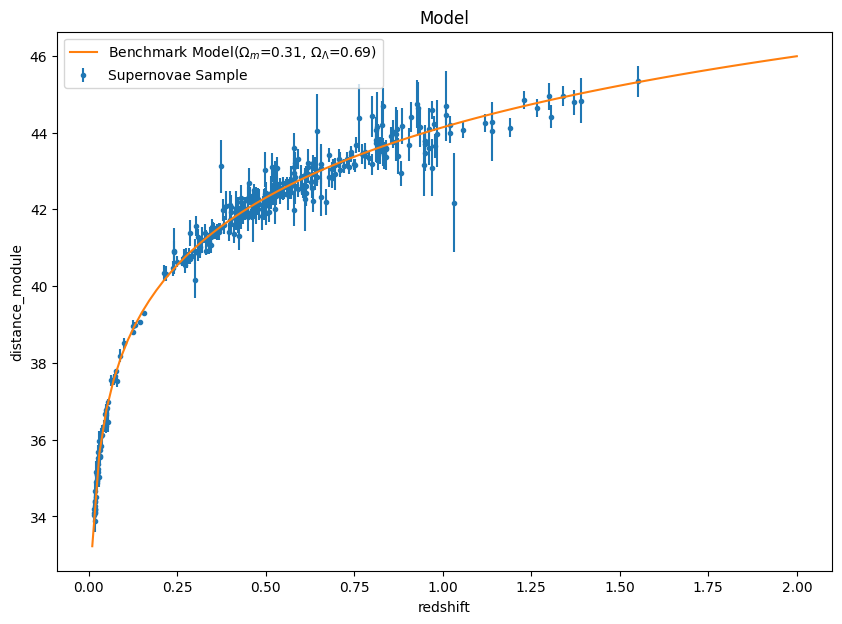

In [ ]:
benchmarkModel = Model("Benchmark Model", 0.31, 0.69)
plot_model(scp, benchmarkModel)

# 2)

In [ ]:
samples = mcmc(scp, N = 5000, steps_std = 0.1, initial_point = 0.5, offset = 100)

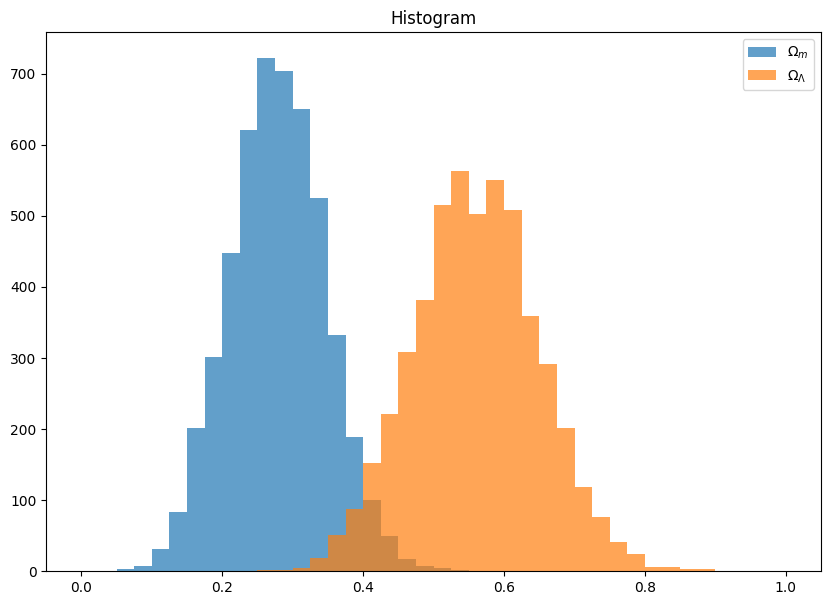

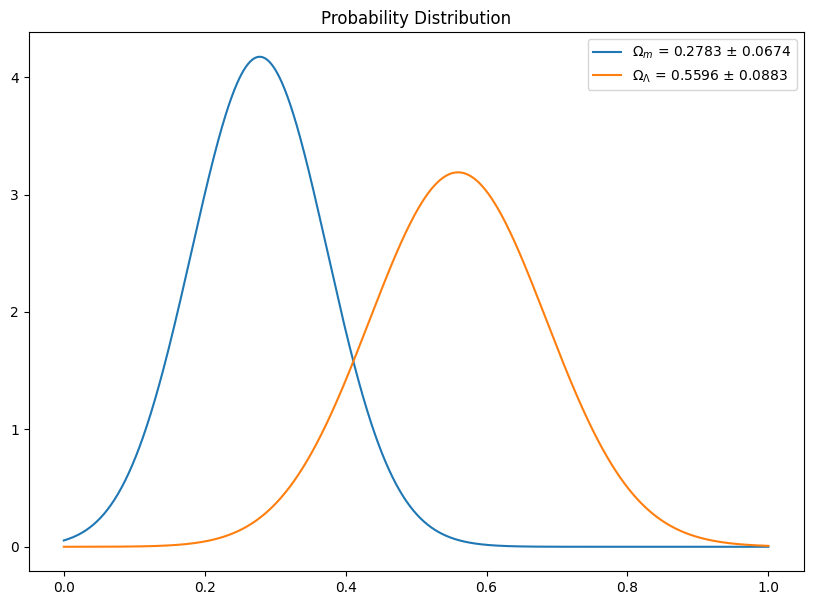

In [ ]:
plot_hist(samples, 40)
plot_distribution(samples)

# 3)

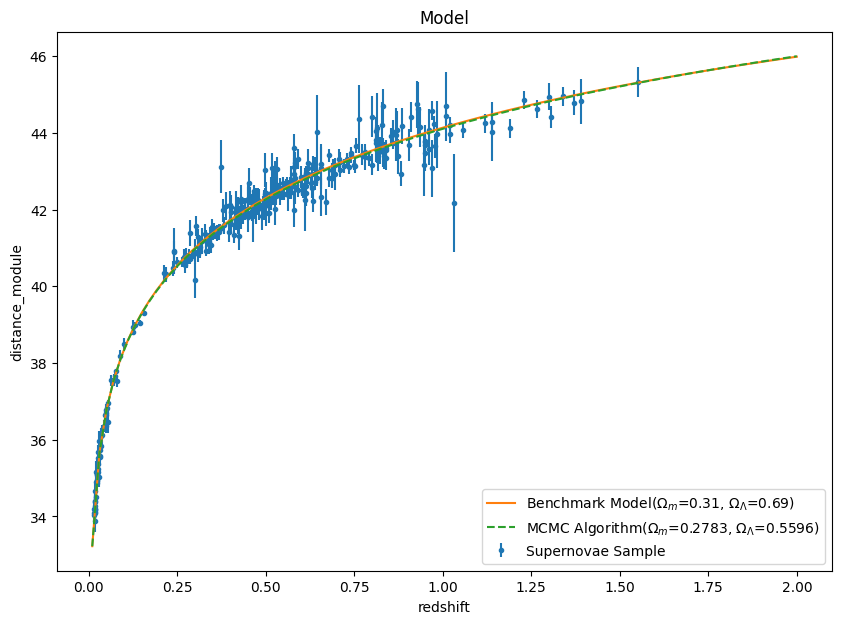

In [ ]:
mcmcModel = Model("MCMC Algorithm", *distribution(samples, 1000)[0])
plot_model(scp, benchmarkModel, mcmcModel)

# 4)

In [ ]:
optimal_point = gradient_descent(scp, 1000, 0.01)

100%|██████████| 1000/1000 [01:11<00:00, 14.02it/s]


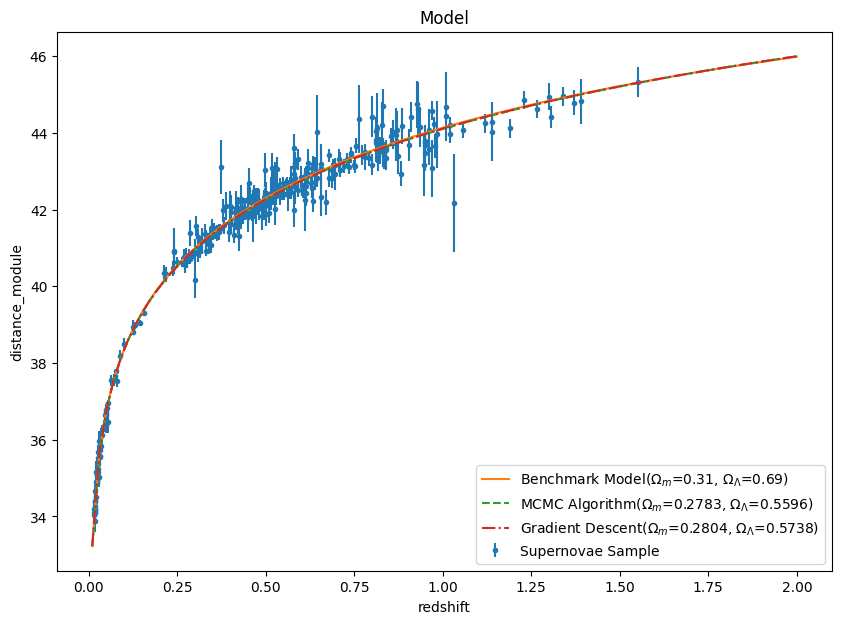

In [ ]:
gdModel = Model("Gradient Descent", *optimal_point)
plot_model(scp, benchmarkModel, mcmcModel, gdModel)